In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import string
import warnings
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation
warnings.filterwarnings("ignore")


In [2]:
# Load the dataset
amazon_book_df = pd.read_csv("/Users/swarnima/Desktop/Capstone/books_data.csv")
amazon_book_df.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


In [3]:
# Drop unimportant columns
amazon_book_df.drop(['image','previewLink','infoLink','ratingsCount','authors','publisher','publishedDate'], inplace=True, axis=1)
amazon_book_df.head()

,Title,description,categories
0,Its Only Art If Its Well Hung!,NaN,['Comics & Graphic Novels']
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Biography & Autobiography']
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['Religion']
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Fiction']
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,NaN


In [4]:
amazon_book_df.shape

(212404, 3)

In [5]:
# Check for null/missing values
amazon_book_df.isna().sum()

Title              1
description    68442
categories     41199
dtype: int64

In [6]:
# Drop rows where the description is missing
amazon_book_df.dropna(subset=['description'], inplace=True)
amazon_book_df.isna().sum()

Title             0
description       0
categories     6074
dtype: int64

In [7]:
amazon_book_df.shape

(143962, 3)

In [8]:
len(amazon_book_df['categories'].unique())

5416

In [9]:
amazon_book_df['categories'].unique()

array(["['Biography & Autobiography']", "['Religion']", "['Fiction']",
       ..., "['Tarzan (Fictitious character)']", "['Outlaws']",
       "['Flame in the wind (Motion picture)']"], dtype=object)

In [10]:
# Drop categories as these are not correct
amazon_book_df.drop('categories', inplace=True, axis=1)
amazon_book_df.head()

,Title,description
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...
8,Saint Hyacinth of Poland,The story for children 10 and up of St. Hyacin...


In [11]:
# Function to clean the description
wn = nltk.WordNetLemmatizer()

def clean_description(desc):
    # Lowercase the review
    desc= desc.lower()
    
    # Remove URLs, links
    desc = re.sub(r"http\S+", "", desc)
    desc = re.sub(r"www.\S+", "", desc)
    desc = re.sub(r"\S+@\S+", "", desc)
    
    # Remove punctuations
    desc_punc = "".join(char for char in desc if char not in string.punctuation)
    
    # Remove stopwords
    stopword = nltk.corpus.stopwords.words('english')
    desc_stopwords = " ".join([word for word in re.split('\W+', desc_punc) if word not in stopword])
    
    # Lemmatization
    desc_cleaned = " ".join([wn.lemmatize(word,'n') for word in re.split('\W+', desc_stopwords)])

    return desc_cleaned

In [12]:
# Clean Description
amazon_book_df['clean_description'] = amazon_book_df['description'].apply(clean_description)
amazon_book_df.head()

,Title,description,clean_description
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,philip nel take fascinating look key aspect se...
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,resource includes twelve principle understandi...
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,julia thomas find life spinning control death ...
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,church christ biblical ecclesiology today resp...
8,Saint Hyacinth of Poland,The story for children 10 and up of St. Hyacin...,story child 10 st hyacinth dominican planted f...


In [13]:
# Drop the old 'description' column
amazon_book_df.drop('description', inplace= True, axis=1)
amazon_book_df.head()

,Title,clean_description
1,Dr. Seuss: American Icon,philip nel take fascinating look key aspect se...
2,Wonderful Worship in Smaller Churches,resource includes twelve principle understandi...
3,Whispers of the Wicked Saints,julia thomas find life spinning control death ...
5,The Church of Christ: A Biblical Ecclesiology ...,church christ biblical ecclesiology today resp...
8,Saint Hyacinth of Poland,story child 10 st hyacinth dominican planted f...


In [14]:
# Using Count Vectorizer
cv = CountVectorizer(min_df = 100)
amazon_book = cv.fit_transform(amazon_book_df['clean_description']).todense()

In [15]:
# Performing LDA
lda = LatentDirichletAllocation(n_components=10, random_state = 20)
amazon_book_genres = lda.fit_transform(amazon_book)

In [16]:
amazon_book_genres

array([[0.00192342, 0.11186926, 0.69841732, ..., 0.06139523, 0.00192348,
        0.00192347],
       [0.00555712, 0.00555767, 0.00555684, ..., 0.00555775, 0.00555739,
        0.15746982],
       [0.00116292, 0.10325086, 0.00116291, ..., 0.00116306, 0.00116296,
        0.0011629 ],
       ...,
       [0.00135161, 0.41215264, 0.00135173, ..., 0.00135154, 0.00135167,
        0.34941383],
       [0.00161314, 0.0522669 , 0.19263287, ..., 0.14037741, 0.05884173,
        0.00161315],
       [0.25097589, 0.13822533, 0.00175468, ..., 0.00175485, 0.00175479,
        0.00175457]])

In [17]:
# Perform KMeans Clustering
kmeans = KMeans(n_clusters=10)
kmeans.fit(amazon_book_genres)

KMeans(n_clusters=10)

In [18]:
# TSNE for visualizing the clusters
genres_tsne = TSNE(n_components=2, perplexity=5, random_state=0).fit_transform(amazon_book_genres)

<AxesSubplot:>

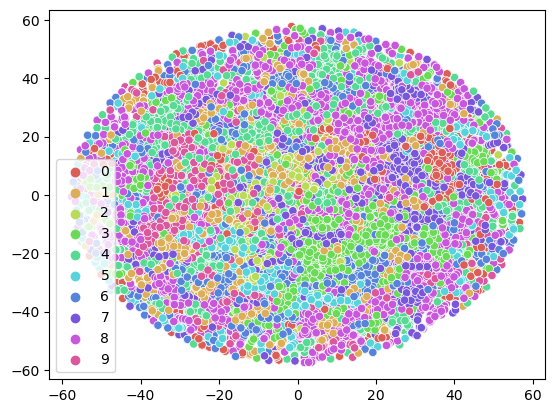

In [19]:
sns.scatterplot(x = genres_tsne[:,0], y = genres_tsne[:,1], hue = kmeans.labels_, palette = sns.hls_palette(10), legend = 'full')

In [20]:
# Dictionary that holds the indices of the values in each cluster
mydict = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}

dictlist = []
for key, value in mydict.items():
    temp = [key,value]
    dictlist.append(temp)

  0%|                                                    | 0/10 [00:00<?, ?it/s]

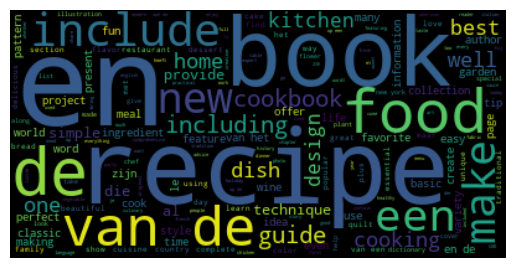

 10%|████▍                                       | 1/10 [00:01<00:16,  1.86s/it]

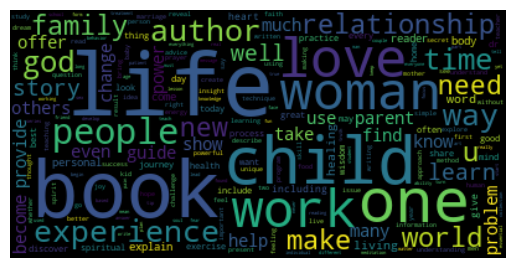

 20%|████████▊                                   | 2/10 [00:06<00:25,  3.24s/it]

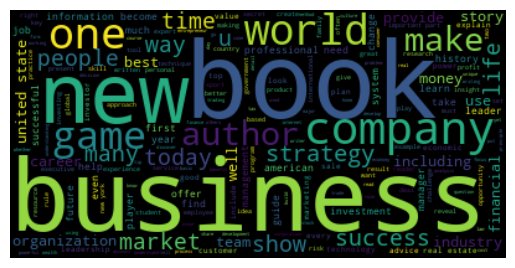

 30%|█████████████▏                              | 3/10 [00:08<00:18,  2.71s/it]

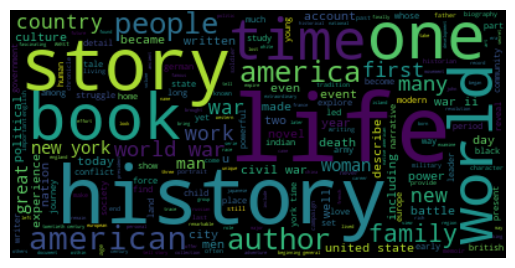

 40%|█████████████████▌                          | 4/10 [00:12<00:20,  3.50s/it]

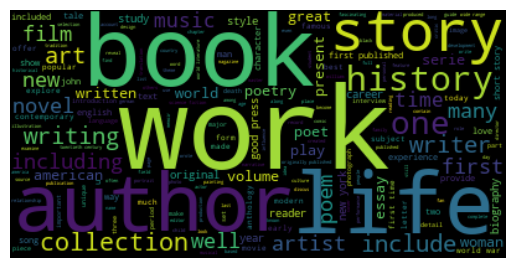

 50%|██████████████████████                      | 5/10 [00:16<00:17,  3.55s/it]

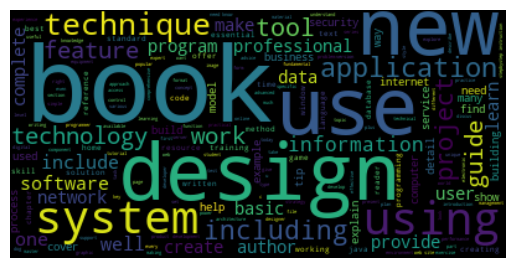

 60%|██████████████████████████▍                 | 6/10 [00:18<00:12,  3.09s/it]

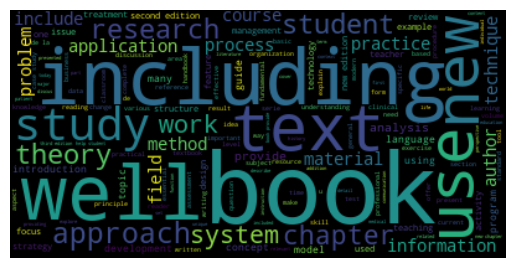

 70%|██████████████████████████████▊             | 7/10 [00:22<00:10,  3.39s/it]

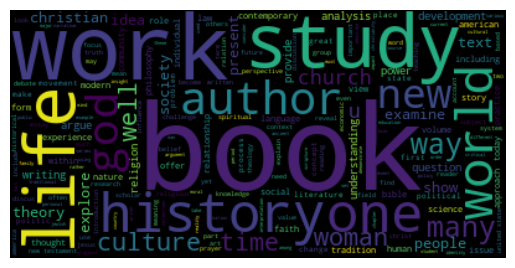

 80%|███████████████████████████████████▏        | 8/10 [00:27<00:07,  3.78s/it]

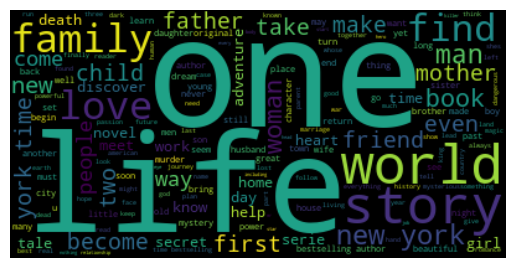

 90%|███████████████████████████████████████▌    | 9/10 [00:35<00:05,  5.10s/it]

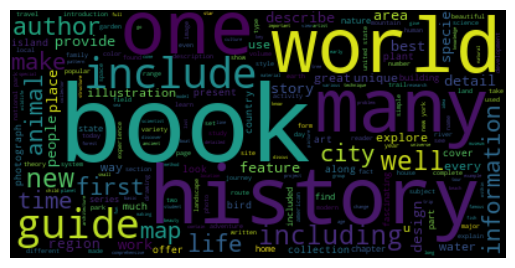

100%|███████████████████████████████████████████| 10/10 [00:37<00:00,  3.75s/it]


In [27]:
# Generate word clouds for each cluster to get the topic of that cluster
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tqdm import tqdm

for i in tqdm(range(10)):
    text = []
    for j in range(len(dictlist[i][1])):
        text.append(amazon_book_df['clean_description'].iloc[dictlist[i][1][j]])
    new_text = (" ").join(text)

    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(new_text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()